In [1]:
import numpy as np

import scipy.linalg as LA
import scipy.io as sio

import matplotlib.pyplot as plt

import theano
import theano.tensor as T

%matplotlib inline

In [2]:
### Parameters from learning; be sure to update when plotting new functions 

batch_size = 15000 # number of img patches to train on
img_length = 12 # dimension of img patch
img_size = img_length**2 
oc = 1 # overcompleteness
num_neurons = oc * img_size
BUFF = 4
lamb = 0.001 # sparsity weight
eta = 1e-6 # learning rate
rank = 4

In [3]:
"""
### CASE WHEN WE ARE DEALING WITH SYMMETRIC H TENSOR ###

# load and split up the data, which was stored as a vector
A_and_H = np.loadtxt('results_1.txt')

# turn the H data into a tensor that is symmetric in the last two indices
triupp_ind = np.triu_indices(img_size)
triu_length = (triupp_ind[0].shape)[0]
H_indices = (np.repeat(np.arange(num_neurons), triu_length), 
            np.tile(triupp_ind[0], num_neurons),
            np.tile(triupp_ind[1], num_neurons))
H_di_indices = (np.repeat(np.arange(num_neurons), img_size), np.tile(np.arange(img_size),num_neurons), np.tile(np.arange(img_size),num_neurons))

def make_sym_H(H_vec):
    h = np.zeros((num_neurons, img_size, img_size))
    h[H_indices] = H_vec
    h = h + np.transpose(h, axes=(0,2,1))
    h[H_di_indices] /= 2.
    return h

def split_AH_sym(A_and_H):
    a, h = np.split(A_and_H, [(img_size * num_neurons)])
    a = a.reshape(img_size, num_neurons)
    h = make_sym_H(h)
    return a, h

A, H = split_AH_sym(A_and_H)
"""

A_and_L = np.loadtxt('results-1.txt')
A, L = np.split(A_and_L, [img_size * num_neurons])
A = A.reshape(img_size, num_neurons)
L = L.reshape(num_neurons, img_size, rank)

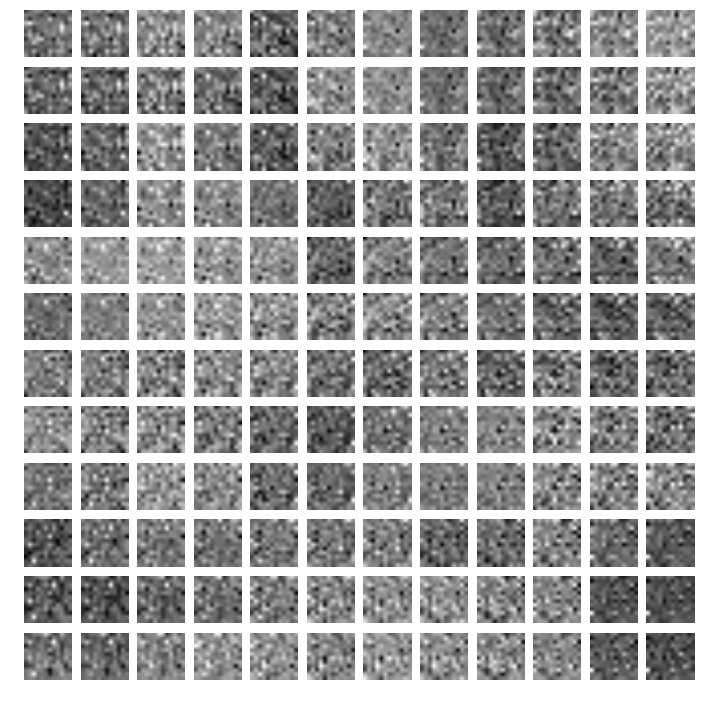

In [4]:
### Plot the basis functions (A matrix)

#A = A/np.sqrt((A**2).sum(axis = 0, keepdims = True))
grid = 12
plt.figure(figsize = (grid,grid))

for i in xrange(grid**2):
    plt.subplot(grid,grid,i+1)
    plt.imshow(A[i,:].reshape(12,12), cmap='gray')
    plt.axis('off')

plt.show()

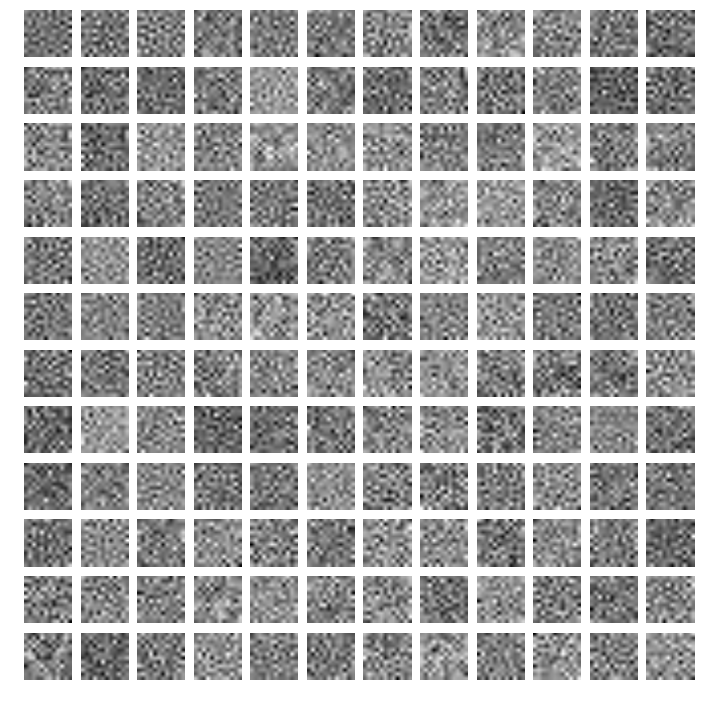

In [8]:
### Plot the eigenvectors corresponding to the largest eigenvalues of the matrices in the H tensor

grid = 12
plt.figure(figsize = (grid,grid))
for i in xrange(grid):
    w,v = LA.eigh(H[i])
    for j in xrange(grid):
        plt.subplot(grid, grid, grid * i + j + 1)
        plt.imshow(v[:,-j].reshape(12,12), cmap='gray')
        plt.axis('off')

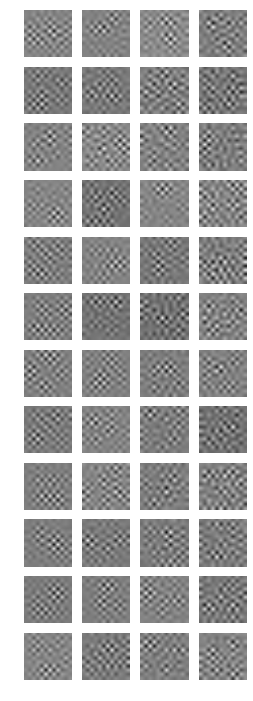

In [5]:
### Plot the eigenvectors corresponding to the largest eigenvalues of the matrices in the L tensor

H = np.einsum('ijk,ikl->ijl', L, np.transpose(L, axes=(0,2,1)))
grid = 12
plt.figure(figsize = (rank,grid))
for i in xrange(grid):
    w,v = LA.eigh(H[i])
    for j in xrange(rank):
        plt.subplot(grid, rank, rank * i + j + 1)
        plt.imshow(v[:,-j-1].reshape(12,12), cmap='gray')
        plt.axis('off')

In [40]:
### choose a test set and calculate the error 

# theano variables
x = T.dmatrix('x')
# basis functions
A_th = T.dmatrix('A')
# weight tensor
H_th = T.dtensor3('H')
# cost functions
s = ((T.tensordot(H_th, x, axes=[[2], [0]]))*x.dimshuffle('x', 0, 1)).sum(axis = 1) # create activity vector from tensor
x_hat = T.dot(A_th, s) # estimate for x 
# cost functions
recon_cost = 0.5*((x_hat - x)**2).sum(axis=0).mean()
sparsity_cost = abs(s).mean(axis = 0).mean()
total_cost = recon_cost + lamb * sparsity_cost
cost_th = theano.function([x, A_th, H_th], total_cost)
recon_th = theano.function([x, A_th, H_th], recon_cost)
sparse_th = theano.function([x, H_th], sparsity_cost)
s2n = theano.function([A_th, H_th, x], (x.var(axis = 0)/(x - x_hat).var(axis = 0)).mean())

images = sio.loadmat('IMAGES.mat')
images = images['IMAGES']
img_length_x, img_length_y, num_img = images.shape
test_set_size = 10000

def get_img_patch():
    patches = np.zeros((img_size, test_set_size))
    for j in xrange(test_set_size):
        row = BUFF + int((img_length_x-img_length-2.*BUFF)*np.random.rand())
        col = BUFF + int((img_length_y-img_length-2.*BUFF)*np.random.rand())
        patches[:, j] = images[row:row+img_length,
                               col:col+img_length,
                               int(num_img * np.random.rand())].ravel()
    return patches

patches = get_img_patch()
print cost_th(patches, A, H)
print recon_th(patches, A, H)
print sparse_th(patches, H)
print s2n(A, H, patches)

124.69457147
124.694442085
0.129384988164
3.73004744738


In [18]:
ruff = np.array([[3.,5,6],[4,12,8]])
print ruff
print ruff/np.sqrt((ruff**2).sum(axis = 0, keepdims = True))

[[  3.   5.   6.]
 [  4.  12.   8.]]
[[ 0.6         0.38461538  0.6       ]
 [ 0.8         0.92307692  0.8       ]]


In [23]:
import theano
import theano.tensor as T

In [58]:
ruff = np.array([[1.,0],[0,-1]])
S = np.resize(ruff, (2,2,2))
L = T.ftensor3('l')
f = theano.function([L], T.batched_tensordot(L, S, axes=1), allow_input_downcast=True)

In [60]:
pew = np.array([[[1.,2],[3,4]],[[4,5],[6,7]]])
print pew
print S
f(pew)

[[[ 1.  2.]
  [ 3.  4.]]

 [[ 4.  5.]
  [ 6.  7.]]]
[[[ 1.  0.]
  [ 0. -1.]]

 [[ 1.  0.]
  [ 0. -1.]]]


array([[[ 1., -2.],
        [ 3., -4.]],

       [[ 4., -5.],
        [ 6., -7.]]])

In [1]:
import numpy as np

In [4]:
ruff = np.array([[1.,0],[0,-1]])
S = np.resize(ruff, (100,2,2))

In [6]:
print S.shape

(100, 2, 2)
